**Import necessary libraries**

In [1]:
import torch
import torchvision
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import random
import os
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Compose, Normalize
from torchvision.datasets import MNIST
from PIL import Image
from torchvision.models.feature_extraction import create_feature_extractor
from sklearn.metrics import precision_score, recall_score, roc_auc_score, confusion_matrix, multilabel_confusion_matrix
from sklearn.preprocessing import label_binarize

In [4]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


**Data Loading and Preprocessing**

In [5]:
# Original transformation
original_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
])

# Augmented transformation with horizontal flip and random rotation
augmented_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=1.0), 
    # Randomly rotate images in the range (-15, 15) degrees
    transforms.RandomRotation(degrees=15),   
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [6]:
# Load the dataset from the root directory
raw_dataset = datasets.ImageFolder(root='dataset', transform=None)

# Access a raw image and its label directly
raw_img, label = raw_dataset[0]

# Now apply the transformations to the raw PIL image for demonstration
img_original_tensor = original_transform(raw_img)
img_augmented_tensor = augmented_transform(raw_img)

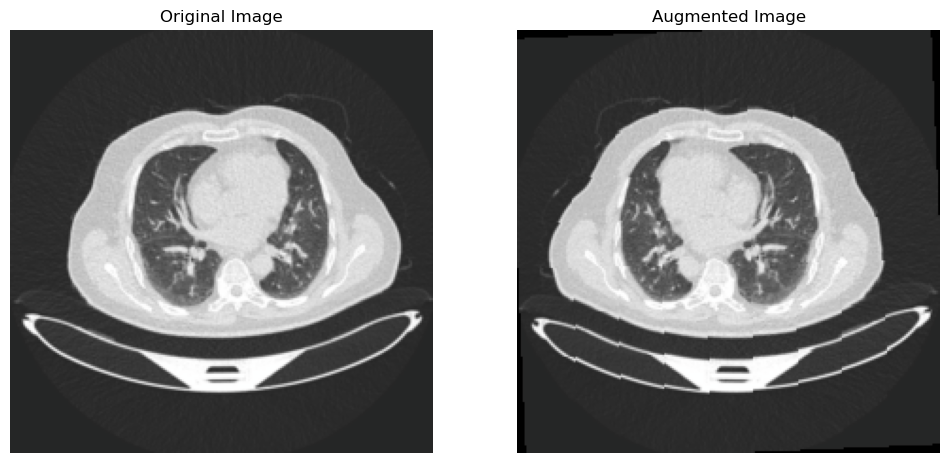

In [7]:
# Access the raw image and its label from dataset
img, label = raw_dataset[0]

# Define the function to unnormalize and show the image
def show_image(img, title=None, ax=None):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  
    img = np.clip(img, 0, 1)
    if ax is not None:
        ax.imshow(img)
        if title is not None:
            ax.set_title(title)
        ax.axis('off')
    else:
        plt.imshow(img)
        if title is not None:
            plt.title(title)
        plt.pause(0.001)  

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Displaying the original image and the augmented image
show_image(img_original_tensor, title='Original Image', ax=axs[0])
show_image(img_augmented_tensor, title='Augmented Image', ax=axs[1])

plt.show()

In [8]:
dataset = datasets.ImageFolder(root='dataset', transform=augmented_transform)

# Splitting the dataset
train_size = int(0.7 * len(dataset)) 
val_size = int(0.15 * len(dataset)) 
test_size = len(dataset) - train_size - val_size 

# Extracting labels from the dataset
targets = [s[1] for s in dataset.samples]  

# Splitting the dataset into train+val and test sets
train_val_idx, test_idx = train_test_split(
    range(len(targets)),
    test_size=test_size / len(dataset),  
    stratify=targets,
    random_state=42  
)

# Splitting train+val into training and validation sets
train_idx, val_idx = train_test_split(
    train_val_idx,
    test_size=val_size / (train_size + val_size),  
    stratify=[targets[i] for i in train_val_idx],
    random_state=42  
)

# Creating subsets for each split
train_dataset = Subset(dataset, train_idx)
validation_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

# Creating data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

**Define the Model**

In [9]:
class CNN_for_LungCancer(nn.Module):
    def __init__(self, dropout_rate, fc_units):
        super(CNN_for_LungCancer, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  
        self.act1 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(dropout_rate)  
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)   
        
        #self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        #self.bn3 = nn.BatchNorm2d(128)
        #self.act3 = nn.ReLU()
        #self.dropout3 = nn.Dropout(dropout_rate)  

        #self.fc1 = nn.Linear(in_features=128 * 28 * 28, out_features=fc_units)
        self.fc1 = nn.Linear(in_features=64 * 56 * 56, out_features=fc_units)
        self.fc2 = nn.Linear(fc_units, 3)
        self.dropout4 = nn.Dropout(dropout_rate)


    def forward(self, x):
        x = self.pool(self.bn1(self.act1(self.conv1(x))))
        x = self.dropout1(x)
        x = self.pool(self.bn2(self.act2(self.conv2(x))))
        x = self.dropout2(x)
        #x = self.pool(self.bn3(self.act3(self.conv3(x))))
        #x = self.dropout3(x)
        x = torch.flatten(x, 1)
        x = self.dropout4(self.fc1(x))
        x = self.fc2(x)

        return x

**Initialize Model, Loss Function, and Optimizer**

In [10]:
model = CNN_for_LungCancer(dropout_rate=0.5, fc_units=64)
model.to(device)  

CNN_for_LungCancer(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=200704, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
  (dropout4): Dropout(p=0.5, inplace=False)
)

**Train and evaluate the model**

In [11]:
# Initialize lists to store accuracies and losses
train_accuracies = []
test_accuracies = []
validation_accuracies = []

train_losses = []
test_losses = []
validation_losses = []

In [12]:
def train_and_evaluate(model, train_loader, validation_loader, test_loader, epochs=10, lr=0.0001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Initialize Optimizer and Loss Function
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), 
                           lr=lr,
                           weight_decay=1e-4, 
                           betas=(0.9, 0.999),
                           eps=1e-8,
                           amsgrad=True)
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss / len(train_loader))

        # Validation phase
        model.eval()
        correct_validation = 0
        total_validation = 0
        validation_loss = 0
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                validation_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_validation += labels.size(0)
                correct_validation += (predicted == labels).sum().item()

        validation_accuracy = 100 * correct_validation / total_validation
        validation_accuracies.append(validation_accuracy)
        validation_losses.append(validation_loss / len(validation_loader))

        # Evaluate on the test set
        test_loss = 0 
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        test_accuracy = 100 * correct_test / total_test
        test_accuracies.append(test_accuracy)
        test_losses.append(test_loss / len(test_loader))

        print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader):.4f}, "
              f"Validation Loss: {validation_loss/len(validation_loader):.4f}, "
              f"Test Loss: {test_loss/len(test_loader):.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%, "
              f"Validation Accuracy: {validation_accuracy:.2f}%, "
              f"Test Accuracy: {test_accuracy:.2f}%")
        print("--------------------------------------------------------------")

In [13]:
train_and_evaluate(model, train_loader, validation_loader, test_loader, epochs=10, lr=1e-3)

Epoch 1, Train Loss: 49.1000, Validation Loss: 9.3491, Test Loss: 11.9376, Train Accuracy: 58.80%, Validation Accuracy: 70.73%, Test Accuracy: 63.86%
--------------------------------------------------------------
Epoch 2, Train Loss: 16.9561, Validation Loss: 9.8255, Test Loss: 12.0683, Train Accuracy: 71.84%, Validation Accuracy: 70.12%, Test Accuracy: 69.88%
--------------------------------------------------------------
Epoch 3, Train Loss: 10.9002, Validation Loss: 15.9972, Test Loss: 16.0396, Train Accuracy: 77.31%, Validation Accuracy: 64.63%, Test Accuracy: 60.84%
--------------------------------------------------------------
Epoch 4, Train Loss: 6.7143, Validation Loss: 3.4385, Test Loss: 3.6434, Train Accuracy: 82.53%, Validation Accuracy: 85.98%, Test Accuracy: 87.35%
--------------------------------------------------------------
Epoch 5, Train Loss: 5.3599, Validation Loss: 19.5663, Test Loss: 21.4208, Train Accuracy: 85.53%, Validation Accuracy: 64.63%, Test Accuracy: 61.45%

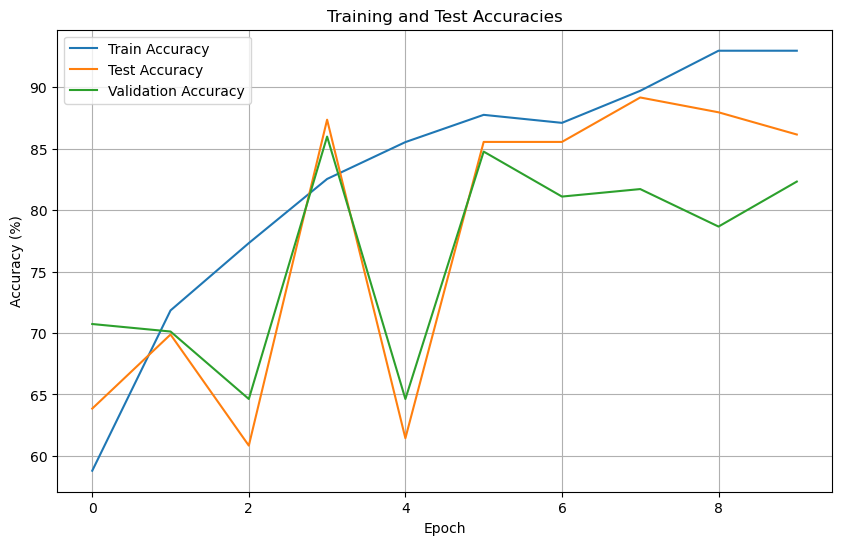

In [14]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracies')
plt.legend()
plt.grid(True)
plt.show()

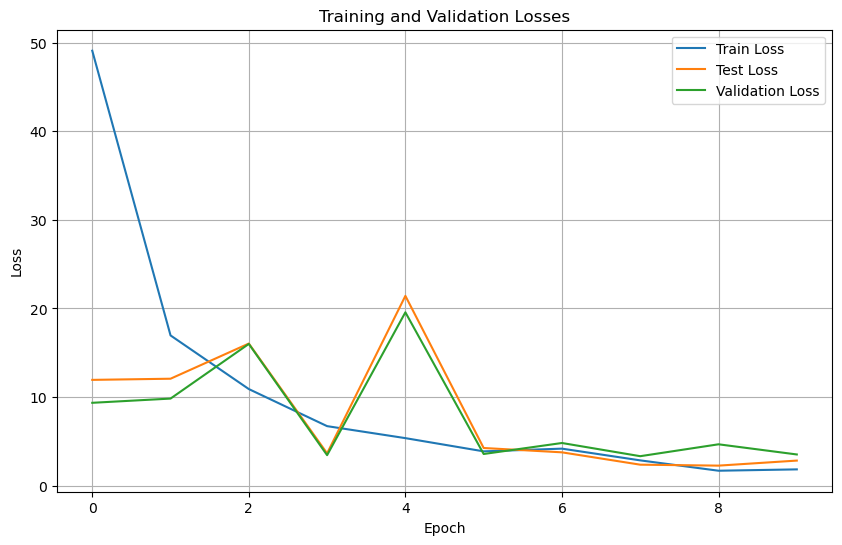

In [15]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()